In [4]:
import numpy as np
import nengo
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from network_revised import DotPerception, build_network
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [46]:
def make_hanks_behavior_dataframe():
    # convert original matlab files into a single pandas dataframe
    dfs = []
    columns = ('type', 'id', 'emphasis', 'trial', 'coherence', 'accuracy', 'RT')

    for name in ['E', 'D']:
        if name=='E': emp = scipy.io.loadmat("data/behavData_eli.mat", simplify_cells=True)
        if name=='D': emp = scipy.io.loadmat("data/behavData_dam.mat", simplify_cells=True)
        for e, emphasis in enumerate(['speed', 'accuracy']):
            cond = emp['task'][e]
            coherences = 100*cond['data']['coh']
            accuracies = 100*cond['data']['cor']
            rts = 0.001*cond['data']['rt']
            trials = coherences.shape[0]
            for t in range(trials):
                dfs.append(pd.DataFrame([['monkey', name, emphasis, t, coherences[t], accuracies[t], rts[t]]], columns=columns))

    hanks_behavior = pd.concat(dfs, ignore_index=True)
    hanks_behavior.to_pickle("data/hanks2014_behavior.pkl")

In [47]:
make_hanks_behavior_dataframe()

In [100]:
print(hanks_behavior)

         type id  emphasis  trial  coherence  accuracy        RT
0      monkey  E     speed      0        0.0         0  0.552000
1      monkey  E     speed      1       25.6         0  0.582000
2      monkey  E     speed      2       51.2       100  0.333000
3      monkey  E     speed      3        6.4       100  0.485000
4      monkey  E     speed      4        0.0       100  0.420000
...       ... ..       ...    ...        ...       ...       ...
16407  monkey  D  accuracy   3302       12.8       100  0.339500
16408  monkey  D  accuracy   3303        0.0         0  0.388950
16409  monkey  D  accuracy   3304       25.6       100  0.474850
16410  monkey  D  accuracy   3305       12.8       100  0.431425
16411  monkey  D  accuracy   3306       25.6         0  0.293025

[16412 rows x 7 columns]


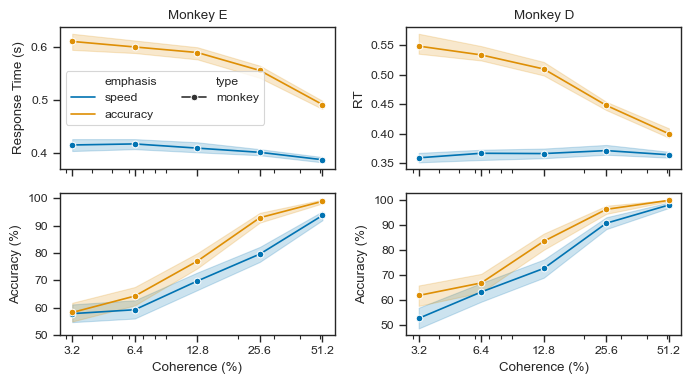

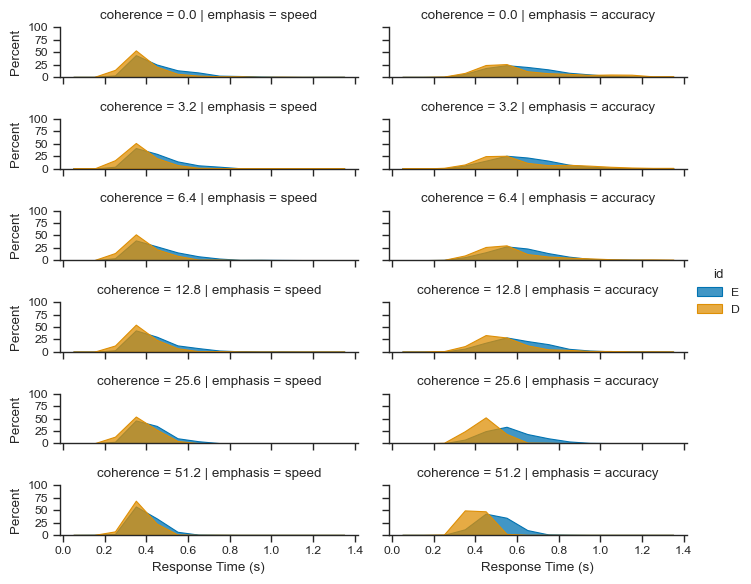

In [80]:
hanks_behavior = pd.read_pickle("data/hanks2014_behavior.pkl")
cohs = 100*np.array([0.032, 0.064, 0.128, 0.256, 0.512])
error = ('ci', 95)
estimator = np.median
bins = np.arange(0, 1.5, 0.1)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=((7.08, 4)))
for pid, name in enumerate(['E', 'D']):
    sns.lineplot(data=hanks_behavior.query("id==@name & coherence>0"), x='coherence', y='RT', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0][pid],
                 style='type', errorbar=error, estimator=estimator)
    sns.lineplot(data=hanks_behavior.query("id==@name & coherence>0"), x='coherence', y='accuracy', hue='emphasis',
                 style='type', palette=palette[:2], markers=True, ax=axes[1][pid])
    axes[0][pid].set(title=f"Monkey {name}")
axes[0][0].set(ylabel="Response Time (s)")
axes[0][0].legend(ncols=2)
axes[1][0].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
axes[1][1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
axes[0][1].get_legend().remove()
axes[1][0].get_legend().remove()
axes[1][1].get_legend().remove()
plt.tight_layout()
fig.savefig(f"plots/hanks_SAT.svg")
fig.savefig(f"plots/hanks_SAT.png", dpi=600)

fig = sns.FacetGrid(hanks_behavior, col='emphasis', row="coherence", hue='id', palette=palette[:2], height=1, aspect=3.5, sharex=True, legend_out=True)
fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
fig.set_xlabels("Response Time (s)")
fig.set(xticks=bins[::2])
fig.set(yticks=[0,25,50,75,100])
fig.add_legend()
fig.savefig(f"plots/hanks_RTs.svg")
fig.savefig(f"plots/hanks_RTs.png", dpi=600)

# Simulate

In [5]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

def get_loss(simulated, empirical, coherences, emphases, bins):
    total_loss = 0
    for emphasis in emphases:
        for coherence in coherences:
            rts_sim = simulated.query("emphasis==@emphasis & coherence==@coherence")['RT'].to_numpy()
            rts_emp = empirical.query("emphasis==@emphasis & coherence==@coherence")['RT'].to_numpy()
            hist_rts_sim = np.histogram(rts_sim, bins=bins)[0]
            hist_rts_emp = np.histogram(rts_emp, bins=bins)[0]
            normed_hist_rts_sim = hist_rts_sim / len(rts_sim)
            normed_hist_rts_emp = hist_rts_emp / len(rts_emp)
            chi_loss = chi_squared_distance(normed_hist_rts_sim, normed_hist_rts_emp)
            mean_loss = np.abs(np.mean(rts_sim) - np.mean(rts_emp))
            median_loss = np.abs(np.median(rts_sim) - np.median(rts_emp))
            total_loss += chi_loss
            total_loss += median_loss
            print(emphasis, coherence, chi_loss, median_loss)
    return total_loss

In [6]:
def simulate(
        coherences=np.array([0.0, 0.032, 0.064, 0.128, 0.256, 0.512]),
        emphases=['speed'],
        pid="E",
        ramp=1,
        threshold=0.5,
        sigma=0.5,
        nActions=2,
        nNeurons=500,
        max_rates=nengo.dists.Uniform(80, 100),
        rA=1.5,
        trials=3,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        dt_sample=0.03,
        relative=0,
        load=False,
        error=('ci', 95),
        estimator=np.median,
        tmax=3,
        bins=np.arange(0.0, 1.5, 0.1),
        name="hanks_behavior_default"):
    
    if not load:
        columns = ('type', 'id', 'emphasis', 'trial', 'coherence', 'accuracy', 'RT')  # same as hanks dataframe
        dfs = []
        for emphasis in emphases:
            inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
            for coherence in coherences:
                for trial in range(trials):
                    inputs.create(coherence=coherence)
                    net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                        max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0.01):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > tmax:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    correct = True if choice==inputs.correct else False
                    print(f"emphasis {emphasis}, coherence {coherence}, trial {trial}, RT {RT}")
                    dfs.append(pd.DataFrame([['model', 'S', emphasis, trial, 100*coherence, 100*correct, RT]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
    else:
        data = pd.read_pickle(f"data/{name}.pkl")

    hanks = pd.read_pickle("data/hanks2014_behavior.pkl").query("emphasis in @emphases and id==@pid")
    combined = pd.concat([hanks, data])
    loss = get_loss(combined.query("type=='model'"), combined.query("type=='monkey'"), 100*coherences, emphases, bins)
    print(f"loss {loss}")

    cohs = 100*np.array([0.032, 0.064, 0.128, 0.256, 0.512])
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0],
                 style='type', errorbar=error, estimator=estimator)
    sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',
                 style='type', palette=palette[:2], markers=True, ax=axes[1])
    axes[0].set(xscale='log', ylabel="Response Time (s)")
    axes[0].legend(ncols=2)
    axes[1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/compare_hanks_SAT.svg")
    fig.savefig(f"plots/compare_hanks_SAT.png", dpi=600)
    
    fig = sns.FacetGrid(combined, col='emphasis', row="coherence", hue='type', palette=palette[:2], height=1, aspect=3.5, sharex=True, legend_out=True)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
    fig.set_xlabels("Response Time (s)")
    fig.set(xticks=bins[::2])
    fig.set(yticks=[0,25,50,75,100])
    fig.add_legend()
    fig.savefig(f"plots/compare_hanks_RTs.svg")
    fig.savefig(f"plots/compare_hanks_RTs.png", dpi=600)

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


emphasis speed, coherence 0.0, trial 0, RT 0.41400000000000003
emphasis speed, coherence 0.0, trial 1, RT 0.314
emphasis speed, coherence 0.0, trial 2, RT 0.446
emphasis speed, coherence 0.0, trial 3, RT 0.309
emphasis speed, coherence 0.0, trial 4, RT 0.653
emphasis speed, coherence 0.0, trial 5, RT 0.724
emphasis speed, coherence 0.0, trial 6, RT 0.306
emphasis speed, coherence 0.0, trial 7, RT 0.427
emphasis speed, coherence 0.0, trial 8, RT 0.454
emphasis speed, coherence 0.0, trial 9, RT 0.377
emphasis speed, coherence 0.0, trial 10, RT 0.4
emphasis speed, coherence 0.0, trial 11, RT 0.426
emphasis speed, coherence 0.0, trial 12, RT 0.35100000000000003
emphasis speed, coherence 0.0, trial 13, RT 0.442
emphasis speed, coherence 0.0, trial 14, RT 0.456
emphasis speed, coherence 0.0, trial 15, RT 0.41000000000000003
emphasis speed, coherence 0.0, trial 16, RT 0.6970000000000001
emphasis speed, coherence 0.0, trial 17, RT 0.40900000000000003
emphasis speed, coherence 0.0, trial 18, RT

C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_6172\150977287.py:60: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_6172\150977287.py:63: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',


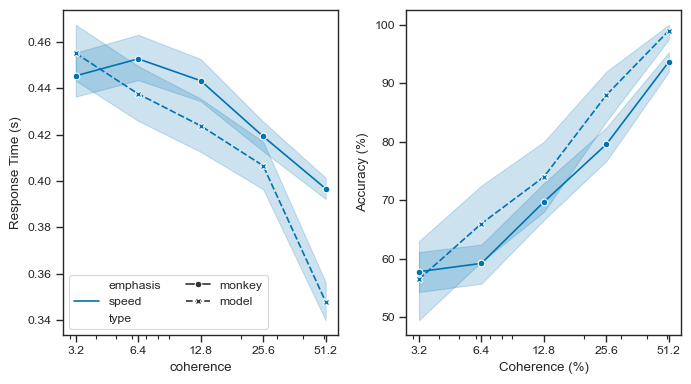

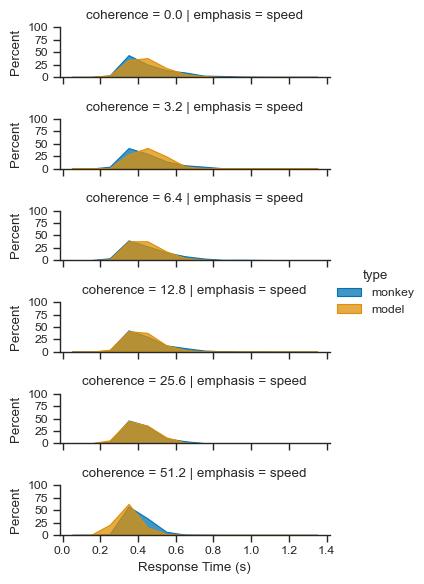

In [21]:
simulate(ramp=1.01, relative=0.15, threshold=0.17, trials=200, load=False, estimator=np.mean, name="dec15speedA")

C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


emphasis accuracy, coherence 0.0, trial 0, RT 0.502
emphasis accuracy, coherence 0.0, trial 1, RT 0.5670000000000001
emphasis accuracy, coherence 0.0, trial 2, RT 0.651
emphasis accuracy, coherence 0.0, trial 3, RT 0.428
emphasis accuracy, coherence 0.0, trial 4, RT 0.52
emphasis accuracy, coherence 0.0, trial 5, RT 0.869
emphasis accuracy, coherence 0.0, trial 6, RT 0.427
emphasis accuracy, coherence 0.0, trial 7, RT 0.517
emphasis accuracy, coherence 0.0, trial 8, RT 0.5760000000000001
emphasis accuracy, coherence 0.0, trial 9, RT 1.024
emphasis accuracy, coherence 0.0, trial 10, RT 0.5720000000000001
emphasis accuracy, coherence 0.0, trial 11, RT 0.71
emphasis accuracy, coherence 0.0, trial 12, RT 0.712
emphasis accuracy, coherence 0.0, trial 13, RT 0.8160000000000001
emphasis accuracy, coherence 0.0, trial 14, RT 0.592
emphasis accuracy, coherence 0.0, trial 15, RT 0.84
emphasis accuracy, coherence 0.0, trial 16, RT 0.501
emphasis accuracy, coherence 0.0, trial 17, RT 0.627
emphasi

C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_16492\150977287.py:60: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_16492\150977287.py:63: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',


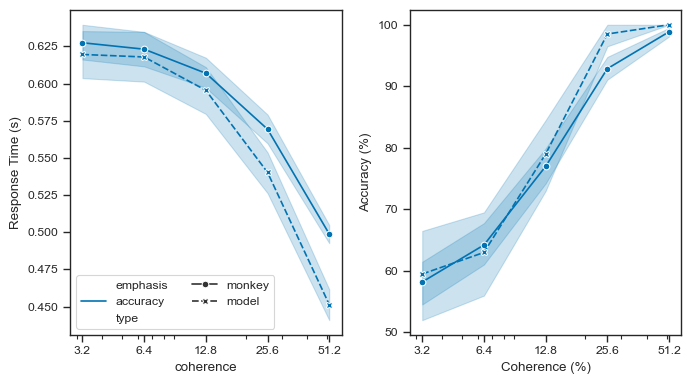

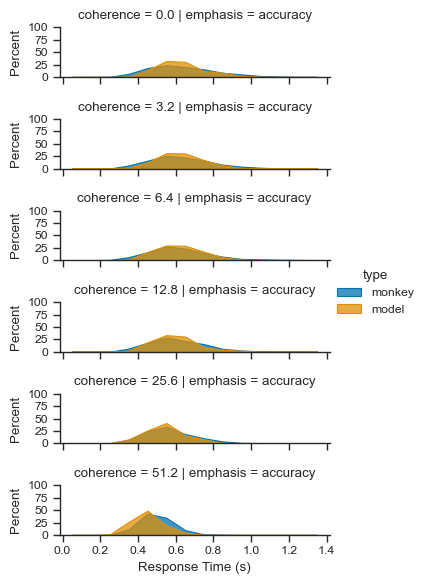

In [4]:
simulate(ramp=2.0, relative=0.25, threshold=0.46, trials=200, load=False, estimator=np.mean, emphases=['accuracy'])

## Replot

In [24]:
def replot_behavior(name1, name2, pid, estimator=np.mean, bins=np.arange(0.0, 1.5, 0.1)):
    data1 = pd.read_pickle(f"data/{name1}.pkl")
    data2 = pd.read_pickle(f"data/{name2}.pkl")

    hanks = pd.read_pickle("data/hanks2014_behavior.pkl").query("id==@pid")
    combined = pd.concat([hanks, data1, data2])
    # loss = get_loss(combined.query("type=='model'"), combined.query("type=='monkey'"), 100*coherences, emphases, bins)
    # print(f"loss {loss}")

    cohs = 100*np.array([0.032, 0.064, 0.128, 0.256, 0.512])
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=((7, 4)))
    sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='RT', hue='emphasis',
                 palette=palette[:2], markers=True, ax=axes[0],
                 style='type', estimator=estimator)
    sns.lineplot(data=combined.query("coherence>0"), x='coherence', y='accuracy', hue='emphasis',
                 style='type', palette=palette[:2], markers=True, ax=axes[1])
    axes[0].set(xscale='log', ylabel="Response Time (s)")
    axes[0].legend(ncols=2)
    axes[1].set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Accuracy (%)", yticks=[50,60,70,80,90,100])
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/compare_hanks_SAT2.svg")
    fig.savefig(f"plots/compare_hanks_SAT2.png", dpi=600)
    
    fig = sns.FacetGrid(combined, col='emphasis', row="coherence", hue='type', palette=palette[:2], height=1, aspect=3, sharex=True, legend_out=True)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
    fig.set_xlabels("Response Time (s)")
    fig.set(xticks=bins[::2])
    fig.set(yticks=[0,25,50,75,100])
    fig.add_legend()
    fig.savefig(f"plots/compare_hanks_RTs2.svg")
    fig.savefig(f"plots/compare_hanks_RTs2.png", dpi=600)

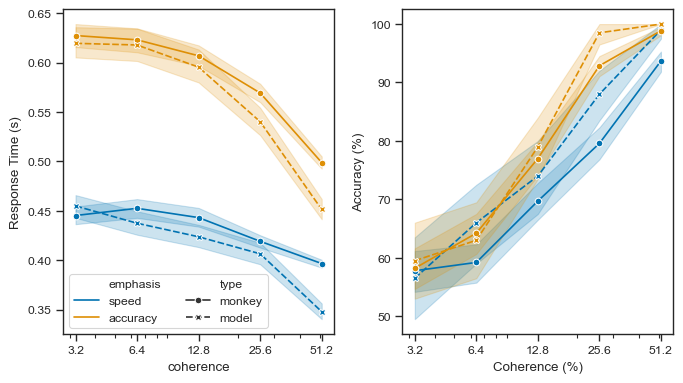

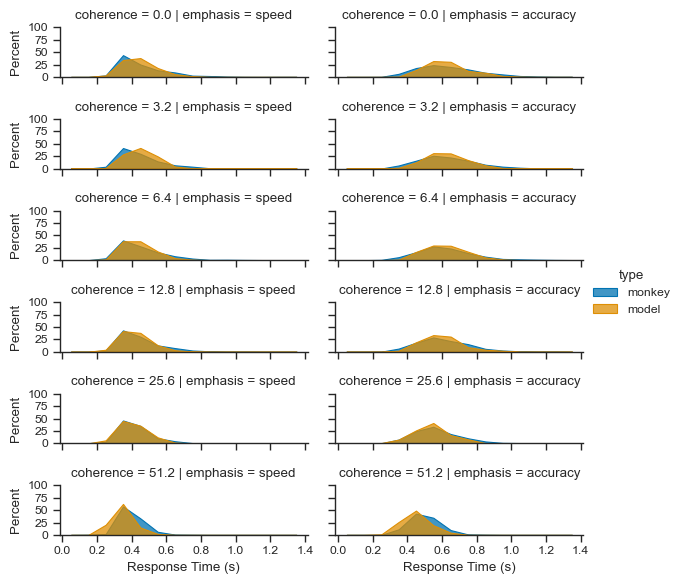

In [25]:
replot_behavior(name1="dec15speedA", name2="dec15accuracyA", pid="E")

# Firing Rates

In [73]:
def firing_rate(
        # coherences=np.array([0.0, 0.032, 0.064, 0.128, 0.256, 0.512]),
        coherences=np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
        emphases=['speed', 'accuracy'],
        pid="E",
        ramp1=1.5,
        threshold1=0.3,
        relative1=0.5,
        ramp2=1,
        threshold2=0.3,
        relative2=0.5,
        sigma=0.5,
        nActions=2,
        nNeurons=500,
        max_rates=nengo.dists.Uniform(80, 100),
        rA=1.5,
        trials=3,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        dt_sample=0.03,
        load=False,
        error=('ci', 95),
        estimator=np.median,
        tmax=3,
        tmin=0.1,
        bins=np.arange(0.0, 1.5, 0.1),
        name="hanks_activity_default"):
    
    if not load:
        columns = ('type', 'id', 'emphasis', 'coherence', 'trial', 'neuron', 'buildup rate',)  # same as hanks dataframe
        dfs = []
        for e, emphasis in enumerate(emphases):
            ramp = [ramp1, ramp2][e]
            threshold = [threshold1, threshold2][e]
            relative = [relative1, relative2][e]
            inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
            for coherence in coherences:
                for trial in range(trials):
                    inputs.create(coherence=coherence)
                    net = build_network(inputs, nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                                        max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative, probe_spikes=True)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0.01):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > tmax:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    correct = True if choice==inputs.correct else False
                    aligned_neuron_idx = np.argwhere(sim.data[net.value].encoders[:,0] > 0.9).ravel()
                    print(f"emphasis {emphasis}, coherence {coherence}, trial {trial}, RT {RT}")
                    DT = RT - tmin
                    for neuron in aligned_neuron_idx:
                        # print(sim.data[net.pSpikes][-1,neuron], sim.data[net.pSpikes][int(tmin/dt),neuron])
                        DA = sim.data[net.pSpikes][-1,neuron] - sim.data[net.pSpikes][int(tmin/dt),neuron]
                        if DA>0:
                            buildup_rate = DA/DT
                            dfs.append(pd.DataFrame([['model', 'S', emphasis, 100*coherence, trial, neuron, buildup_rate]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
    else:
        data = pd.read_pickle(f"data/{name}.pkl")

    cohs = 100*coherences
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=((7, 3)))
    sns.lineplot(data=data, x='coherence', y='buildup rate', hue='emphasis',
                 palette=palette[:2], markers=True, ax=ax, style='type', errorbar=error, estimator=estimator)
    # ax.set(xscale='log', xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Buildup Rate (Hz/s)")
    ax.set(xticks=cohs, xticklabels=cohs, xlabel="Coherence (%)", ylabel="Buildup Rate (Hz/s)")
    ax.legend(ncols=2)
    plt.tight_layout()
    fig.savefig(f"plots/hanks_buildup.svg")
    fig.savefig(f"plots/hanks_buildup.png", dpi=600)

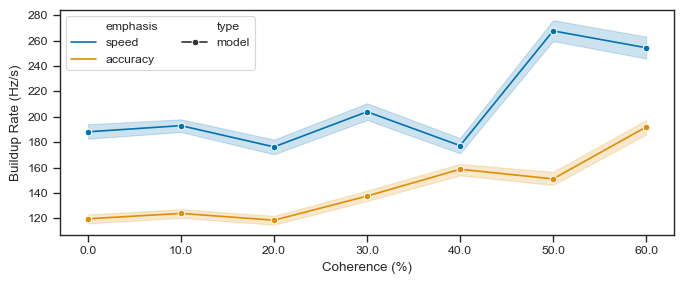

In [89]:
firing_rate(trials=30, load=True, error=("ci", 95), estimator=np.mean,
           ramp1=1.01, relative1=0.15, threshold1=0.17,
           ramp2=2.0, relative2=0.25, threshold2=0.46)

## empirical dataframe

In [57]:
emp = scipy.io.loadmat("data/psthData.mat", simplify_cells=True)

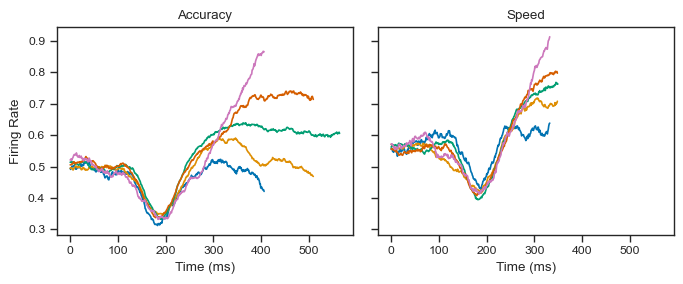

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7, 3)), sharey=True, sharex=True)
sns.lineplot(emp['psth_forBo_acc'][0], color=palette[0], ax=axes[0])
sns.lineplot(emp['psth_forBo_acc'][1], color=palette[1], ax=axes[0])
sns.lineplot(emp['psth_forBo_acc'][2], color=palette[2], ax=axes[0])
sns.lineplot(emp['psth_forBo_acc'][3], color=palette[3], ax=axes[0])
sns.lineplot(emp['psth_forBo_acc'][4], color=palette[4], ax=axes[0])
sns.lineplot(emp['psth_forBo_sp'][0], color=palette[0], ax=axes[1])
sns.lineplot(emp['psth_forBo_sp'][1], color=palette[1], ax=axes[1])
sns.lineplot(emp['psth_forBo_sp'][2], color=palette[2], ax=axes[1])
sns.lineplot(emp['psth_forBo_sp'][3], color=palette[3], ax=axes[1])
sns.lineplot(emp['psth_forBo_sp'][4], color=palette[4], ax=axes[1])
axes[0].set(ylabel='Firing Rate', xlabel='Time (ms)', title='Accuracy')
axes[1].set(xlabel='Time (ms)', title='Speed')
plt.tight_layout()
fig.savefig(f"plots/hanks_psth.png", dpi=600)